# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

170498071/170498071 [==============================] - 3s 0us/step


This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 28x28 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the digit images directly to the model.
    - The two Conv2D layers belows learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](https://github.com/kkapale/ai-science-training-series/blob/withHomework/03_neural_networks_tensorflow/images/conv_layer.png?raw=1)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](https://github.com/kkapale/ai-science-training-series/blob/withHomework/03_neural_networks_tensorflow/images/conv.png?raw=1)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="https://github.com/kkapale/ai-science-training-series/blob/withHomework/03_neural_networks_tensorflow/images/MaxpoolSample2.png?raw=1" width="600" hight="600" align="left"/>

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 55 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 172s 2s/step - loss: 1.8250 - accuracy: 0.3323
Epoch 2/3
98/98 [==============================] - 191s 2s/step - loss: 1.4798 - accuracy: 0.4679
Epoch 3/3
98/98 [==============================] - 191s 2s/step - loss: 1.3521 - accuracy: 0.5162


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

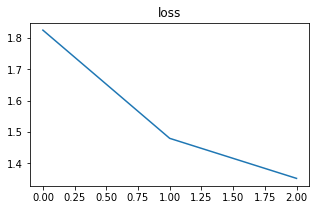

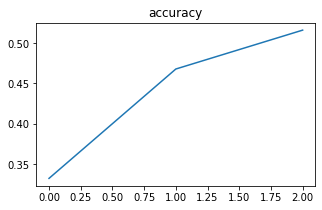

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 99%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). Even more results can be found [here](http://yann.lecun.com/exdb/mnist/).

In [ ]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

We can also again check the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

### More verbose training

This approach explicitly handles the looping over data. It will be helpful this afternoon for diving in and optimizing

In [ ]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [ ]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [ ]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [ ]:
def train_network(_batch_size, _n_training_epochs, _lr):

    mnist_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, mnist_model, opt)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning weight, altering the number of neurons the hidden layer, changing the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.69%, although it varies randomly.

First approach to optimizing: playing with the epochs, lr:

In [7]:
# smaller batch size, larger epochs, and same learning rate
batch_size = 256
epochs = 10
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/10
196/196 [==============================] - 173s 881ms/step - loss: 1.7021 - accuracy: 0.3786
Epoch 2/10
196/196 [==============================] - 172s 875ms/step - loss: 1.3714 - accuracy: 0.5114
Epoch 3/10
196/196 [==============================] - 172s 878ms/step - loss: 1.2127 - accuracy: 0.5678
Epoch 4/10
196/196 [==============================] - 171s 871ms/step - loss: 1.1331 - accuracy: 0.5989
Epoch 5/10
196/196 [==============================] - 170s 866ms/step - loss: 1.0622 - accuracy: 0.6243
Epoch 6/10
196/196 [==============================] - 169s 861ms/step - loss: 1.0045 - accuracy: 0.6436
Epoch 7/10
196/196 [==============================] - 170s 868ms/step - loss: 0.9608 - accuracy: 0.6602
Epoch 8/10
196/196 [==============================] - 169s 865ms/step - loss: 0.9268 - accuracy: 0.6730
Epoch 9/10
196/196 [==============================] - 169s 863ms/step - loss: 0.8850 - accuracy: 0.6882
Epoch 10/10
196/196 [==============================] - 187s 955m

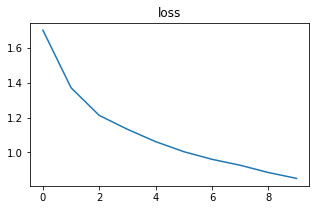

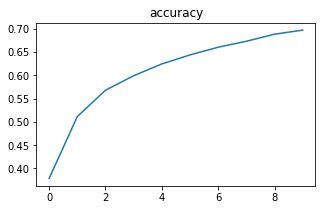

In [8]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [9]:
# same batch size as the previous trial, same epochs as the previous trial, and five times the learning rate
batch_size = 256
epochs = 10
lr = .05
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/10
196/196 [==============================] - 176s 893ms/step - loss: 1.7301 - accuracy: 0.3704
Epoch 2/10
196/196 [==============================] - 171s 871ms/step - loss: 1.3882 - accuracy: 0.5012
Epoch 3/10
196/196 [==============================] - 172s 873ms/step - loss: 1.2372 - accuracy: 0.5595
Epoch 4/10
196/196 [==============================] - 173s 881ms/step - loss: 1.1582 - accuracy: 0.5889
Epoch 5/10
196/196 [==============================] - 173s 882ms/step - loss: 1.0922 - accuracy: 0.6143
Epoch 6/10
196/196 [==============================] - 172s 878ms/step - loss: 1.0401 - accuracy: 0.6312
Epoch 7/10
196/196 [==============================] - 189s 966ms/step - loss: 0.9872 - accuracy: 0.6503
Epoch 8/10
196/196 [==============================] - 187s 954ms/step - loss: 0.9574 - accuracy: 0.6593
Epoch 9/10
196/196 [==============================] - 194s 990ms/step - loss: 0.9184 - accuracy: 0.6737
Epoch 10/10
196/196 [==============================] - 172s 876m

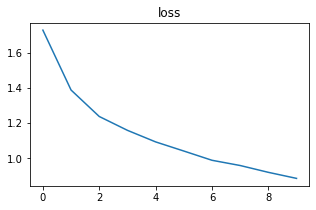

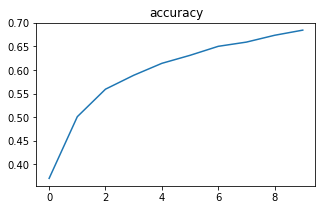

In [10]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

It appears that the learning rate does not help very much. Let us add a couple of more Conv layers.

In [14]:
class CIFAR10Classifier2(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.conv_5 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.conv_6 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu')
        self.pool_7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_8 = tf.keras.layers.Dropout(0.25)
        self.dense_9 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_10 = tf.keras.layers.Dropout(0.25)
        self.dense_11 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.pool_7(x)
        x = self.drop_8(x)
        
        
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_9(x)
        x = self.drop_10(x)
        x = self.dense_11(x)

        return x

In [15]:
def train_network_concise2(_batch_size, _n_training_epochs, _lr):

    cnn_model2 = CIFAR10Classifier2()

    cnn_model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model2.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model2

In [16]:
# smaller batch size, larger epochs, and same learning rate
batch_size = 256
epochs = 10
lr = .01
history, cnn_model2 = train_network_concise2(batch_size, epochs, lr)

Epoch 1/10
196/196 [==============================] - 279s 1s/step - loss: 1.7636 - accuracy: 0.3475
Epoch 2/10
196/196 [==============================] - 278s 1s/step - loss: 1.3826 - accuracy: 0.5004
Epoch 3/10
196/196 [==============================] - 278s 1s/step - loss: 1.2079 - accuracy: 0.5713
Epoch 4/10
196/196 [==============================] - 275s 1s/step - loss: 1.0702 - accuracy: 0.6214
Epoch 5/10
196/196 [==============================] - 273s 1s/step - loss: 0.9811 - accuracy: 0.6545
Epoch 6/10
196/196 [==============================] - 274s 1s/step - loss: 0.8997 - accuracy: 0.6818
Epoch 7/10
196/196 [==============================] - 275s 1s/step - loss: 0.8356 - accuracy: 0.7078
Epoch 8/10
196/196 [==============================] - 273s 1s/step - loss: 0.7783 - accuracy: 0.7246
Epoch 9/10
196/196 [==============================] - 273s 1s/step - loss: 0.7392 - accuracy: 0.7409
Epoch 10/10
196/196 [==============================] - 273s 1s/step - loss: 0.7088 - accura

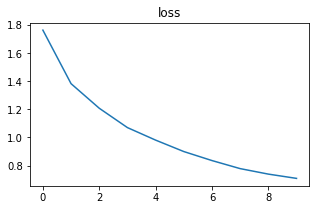

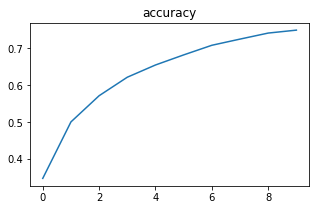

In [17]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

Commet: Adding two extra covolutioal layers helped. Let us see if icreasig epochs helps further.

In [ ]:
# double the epochs
batch_size = 256
epochs = 20
lr = .01
history, cnn_model2 = train_network_concise2(batch_size, epochs, lr)

Epoch 1/20
 45/196 [=====>........................] - ETA: 3:49 - loss: 2.1172 - accuracy: 0.2136

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');